In [1]:
import h5py
import numpy as np
import torch
import torch.utils.data
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [9]:
class ModulationDataSets(Dataset):
    def __init__(self, file):
        self.h5 = h5py.File(file, "r")
        self.label_id = self.h5['sampleType']
        _, self.length = self.label_id.shape
        self.img = self.h5['sampleData']
        self.toTensor = ToTensor()

    def __getitem__(self, idx):
        return self.toTensor(self.img[:, :, idx]).float(), torch.tensor(int(self.label_id[0, idx] - 1),
                                                                        dtype=torch.long), torch.tensor(
            int(self.label_id[1, idx]), dtype=torch.long)

    def __len__(self):
        return self.length

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.h5.close()

In [ ]:
torch.load("basic-8.parm")

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
    nn.Conv2d(10, 20, kernel_size=5), nn.Dropout2d(0.2), nn.MaxPool2d(2), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(11960, 4096), nn.ReLU(),
    nn.Linear(4096, 50), nn.ReLU(),
    nn.Dropout(0),
    nn.Linear(50, 8),
    nn.Softmax()
)
net.load_state_dict(torch.load("basic-8.parm"))
net.eval()

Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (4): Dropout2d(p=0.2, inplace=False)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=11960, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=50, bias=True)
  (11): ReLU()
  (12): Dropout(p=0, inplace=False)
  (13): Linear(in_features=50, out_features=8, bias=True)
  (14): Softmax(dim=None)
)

In [8]:
import more.network

net =more.network.MoreNet()
net.load_state_dict(torch.load("E:/more/pic/close-1/net-close-1.parm"))
net.eval()

MoreNet(
  (conv): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout2d(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=11700, out_features=4096, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4096, out_features=2, bias=True)
  )
  (fc8): Linear(in_features=2, out_features=8, bias=True)
)

In [16]:
X = torch.rand(size=(1, 1, 196, 64), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [17]:
train_path = r'E:\train.h5'
test_path = r'E:\test.h5'
train_dataset = ModulationDataSets(train_path)
test_dataset = ModulationDataSets(test_path)
batch_size = 100
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size,
    shuffle=False, num_workers=0, drop_last=False)

## 提取单独类型

In [10]:
name = ['singlepulse', 'freqdiv', 'LFM', 'QFM', '2FSK', '4FSK', 'BPSK', 'QPSK']

In [12]:
path = r"E:\test-large.h5"
h5 = h5py.File(path)
g_label = h5['sampleType'][:]
g_data = h5['sampleData'][:, :, :]
h5.close()
toTensor = ToTensor()

In [13]:
def filter(type=None, snr=None) -> np.ndarray:
    full = (g_label[0, :] != None)
    if (type != None):
        full = full & (g_label[0, :] == type)
    if (snr != None):
        full = full & (g_label[1, :] == snr)
    # 将TrueFalse数组转换为索引
    ids = np.argwhere(full).reshape(-1)
    return ids


def getData(type, snr):
    ids = filter(type, snr).tolist()
    length = len(ids)
    return g_data[:, :, ids], g_label[0, ids].reshape(1, -1)


class TypeSet(Dataset):
    def __init__(self, type, snr):
        self.img, self.label = getData(type, snr)
        _, self.length = self.label.shape

    def __getitem__(self, idx):
        return toTensor(self.img[:, :, idx]).float(), torch.tensor(self.label[0, idx] - 1, dtype=torch.int)

    def __len__(self):
        return self.length


def getLoader(type, snr):
    set = TypeSet(type, snr)
    #print(set.__len__())
    return torch.utils.data.DataLoader(
        dataset=set, batch_size=set.__len__(), shuffle=False,
        num_workers=0, drop_last=False)


x = getLoader(1, -10)

In [41]:
x, y = getData(1, -10)
x.shape, y.shape

((196, 64, 133), (1, 133))

In [30]:
img, label = next(iter(x))
img.shape, label.shape

C:\Users\ZGYwi\AppData\Local\Temp\ipykernel_3360\3228186593.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return toTensor(self.img[:, :, idx]), torch.tensor(self.label[idx] - 1, dtype=torch.int)


(torch.Size([121, 1, 196, 64]), torch.Size([121]))

In [38]:
ids = filter(1, 2)
x = g_data[:, :, ids].reshape(196, 64, -1)
type(x), x.shape

(numpy.ndarray, (196, 64, 121))

In [ ]:
getData(1, -10)

In [7]:
output = net(img)
output.shape

E:\App\Miniconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([121, 8])

In [14]:
result = np.ndarray((8, 41))
for n in range(1, 1 + len(name)):
    for snr in range(-10, 31):
        img, labels = next(iter(getLoader(n, snr)))
        length = len(labels)
        output = net(img)
        pred = output.data.max(1, keepdim=True)[1].reshape(length)
        pred = pred.numpy()
        labels = labels.reshape(length).numpy()
        err_idx = np.argwhere(pred != labels)
        accuacy=(length - len(err_idx)) * 100 / length
        print("{}:\t {}dB\t accuracy:{}%".format(name[n - 1], snr, (length - len(err_idx)) * 100 / length))
        result[n-1,snr+10]=accuacy
        #SNR_array.append(snr.tolist()[0])
        #accuracy_array.append(80 - 80 * len(err_idx) / 80)

C:\Users\ZGYwi\AppData\Local\Temp\ipykernel_12960\971741046.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return toTensor(self.img[:, :, idx]).float(), torch.tensor(self.label[0, idx] - 1, dtype=torch.int)


singlepulse:	 -10dB	 accuracy:20.32520325203252%
singlepulse:	 -9dB	 accuracy:33.898305084745765%
singlepulse:	 -8dB	 accuracy:39.25925925925926%
singlepulse:	 -7dB	 accuracy:51.09489051094891%
singlepulse:	 -6dB	 accuracy:48.4375%
singlepulse:	 -5dB	 accuracy:54.12844036697248%
singlepulse:	 -4dB	 accuracy:57.48031496062992%
singlepulse:	 -3dB	 accuracy:62.13592233009709%
singlepulse:	 -2dB	 accuracy:71.90082644628099%
singlepulse:	 -1dB	 accuracy:79.48717948717949%
singlepulse:	 0dB	 accuracy:80.61224489795919%
singlepulse:	 1dB	 accuracy:84.32835820895522%
singlepulse:	 2dB	 accuracy:84.15841584158416%
singlepulse:	 3dB	 accuracy:93.44262295081967%
singlepulse:	 4dB	 accuracy:93.16239316239316%
singlepulse:	 5dB	 accuracy:96.22641509433963%
singlepulse:	 6dB	 accuracy:99.21875%
singlepulse:	 7dB	 accuracy:99.18032786885246%
singlepulse:	 8dB	 accuracy:98.4%
singlepulse:	 9dB	 accuracy:97.41379310344827%
singlepulse:	 10dB	 accuracy:100.0%
singlepulse:	 11dB	 accuracy:99.242424242424

In [15]:
result

array([[ 20.32520325,  33.89830508,  39.25925926,  51.09489051,
         48.4375    ,  54.12844037,  57.48031496,  62.13592233,
         71.90082645,  79.48717949,  80.6122449 ,  84.32835821,
         84.15841584,  93.44262295,  93.16239316,  96.22641509,
         99.21875   ,  99.18032787,  98.4       ,  97.4137931 ,
        100.        ,  99.24242424,  99.19354839, 100.        ,
        100.        , 100.        ,  99.21259843, 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        ],
       [ 79.36507937,  79.85074627,  87.73584906,  91.26984127,
         91.2       ,  96.61016949,  91.33858268,  95.38461538,
         96.18320611,  96.06299213,  97.69230769,  98.54014599,
         96.57534247,  97.27272727,  99.10714286,  96.69421488,
         99.20634921,  94.87179487,  95.28301887,  95.61403509,
         97.6    

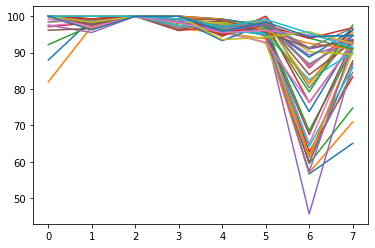

In [57]:
plt.plot(result)

In [20]:
next(iter(test_loader))

[tensor([[[[0.0334, 0.0048, 0.0212,  ..., 0.0110, 0.0237, 0.0098],
           [0.0298, 0.0098, 0.0280,  ..., 0.0155, 0.0214, 0.0210],
           [0.0253, 0.0174, 0.0260,  ..., 0.0178, 0.0255, 0.0175],
           ...,
           [0.0172, 0.0307, 0.0085,  ..., 0.0267, 0.0275, 0.0159],
           [0.0218, 0.0259, 0.0083,  ..., 0.0238, 0.0192, 0.0139],
           [0.0150, 0.0171, 0.0073,  ..., 0.0060, 0.0225, 0.0087]]],
 
 
         [[[0.0069, 0.0040, 0.0028,  ..., 0.0054, 0.0057, 0.0058],
           [0.0048, 0.0067, 0.0014,  ..., 0.0047, 0.0122, 0.0063],
           [0.0027, 0.0088, 0.0025,  ..., 0.0029, 0.0112, 0.0020],
           ...,
           [0.0024, 0.0041, 0.0058,  ..., 0.0029, 0.0043, 0.0037],
           [0.0009, 0.0047, 0.0033,  ..., 0.0038, 0.0063, 0.0048],
           [0.0036, 0.0053, 0.0025,  ..., 0.0048, 0.0049, 0.0008]]],
 
 
         [[[0.0331, 0.0161, 0.0526,  ..., 0.1322, 0.0517, 0.0478],
           [0.0416, 0.0289, 0.0644,  ..., 0.0684, 0.0955, 0.0388],
           [0.0504

7:predict:6 real:0
10:predict:6 real:0
12:predict:7 real:0
18:predict:7 real:0
21:predict:7 real:0
38:predict:7 real:0
48:predict:6 real:0
56:predict:6 real:0
59:predict:6 real:0
69:predict:7 real:0
72:predict:6 real:0
77:predict:4 real:0
83:predict:6 real:0
85:predict:7 real:0
91:predict:6 real:0
94:predict:7 real:0
96:predict:7 real:0
99:predict:6 real:0


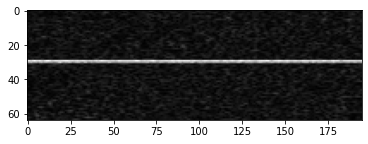

KeyboardInterrupt: 

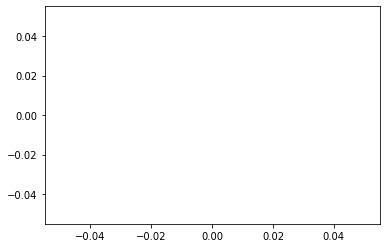

In [24]:
import matplotlib.pyplot as plt

accuacy = []
for img, labels,_ in test_loader:
    length = len(labels)
    output = net(img)
    pred = output.data.max(1, keepdim=True)[1].reshape(length)
    pred = pred.numpy()
    for i,p in enumerate(pred):
        if p==labels[i]:
            continue
        # plt.imshow(img[i, 0, :, :].t(), cmap="gray")
        # plt.title('predict:{} real:{}'.format(name[pred[i]], name[labels[i]]))
        # plt.show()
        print('{}:predict:{} real:{}'.format(i,p, labels[i]))
        err_idx = np.argwhere(pred != labels)
        accuacy.append(100 - len(err_idx))
plt.plot(accuacy)

## 单SNR测试

In [7]:
path = r"E:\test1.h5"
file = h5py.File(path, "r")
file.keys()

<KeysViewHDF5 ['SNRData', 'SNRType']>

In [35]:
file['SNRType']

<HDF5 dataset "SNRType": shape (5, 3280), type "<f8">

In [8]:
file.close()

In [5]:
class SNRDataSets(Dataset):
    def __init__(self, file):
        self.h5 = h5py.File(file, "r")
        self.label_id = self.h5['SNRType']
        _, self.length = self.label_id.shape
        self.img = self.h5['SNRData']
        self.toTensor = ToTensor()

    def __getitem__(self, idx):
        return (self.toTensor(self.img[:, :, idx]).float(),
                torch.tensor(int(self.label_id[0, idx] - 1), dtype=torch.long),
                torch.tensor(self.label_id[1, idx]))

    def __len__(self):
        return self.length

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.h5.close()

In [9]:
snr_dataset = SNRDataSets(path)
snr_loader = torch.utils.data.DataLoader(
    dataset=snr_dataset, batch_size=80,
    shuffle=False, num_workers=0, drop_last=False)

In [45]:
img, label, snr = next(iter(snr_loader))

In [46]:
img.shape

torch.Size([80, 1, 196, 64])

In [47]:
label.shape

torch.Size([80])

In [10]:
SNR_array = []
accuracy_array = []
for img, labels, snr in snr_loader:
    length = len(labels)
    output = net(img)
    pred = output.data.max(1, keepdim=True)[1].reshape(length)
    pred = pred.numpy()
    labels = labels.reshape(length).numpy()
    err_idx = np.argwhere(pred != labels)
    # print("SNR:{} accuracy:{}%".format(snr[0],80-80*len(err_idx)/80))
    SNR_array.append(snr.tolist()[0])
    accuracy_array.append((length - len(err_idx)) / length * 100)

E:\App\Miniconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0, 0.5, 'accuracy')

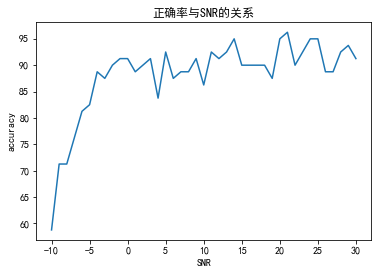

In [12]:
plt.plot(SNR_array, accuracy_array)
plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

plt.title("正确率与SNR的关系")
plt.xlabel("SNR")
plt.ylabel("accuracy")